# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from sklearn.utils import shuffle
#импортируем библиотеку для стандартноо масштабирования
from sklearn.preprocessing import StandardScaler
#импорт библиотек трех моделей
#Деревое решений
from sklearn.tree import DecisionTreeClassifier

#Случайный лес 
from sklearn.ensemble import RandomForestClassifier

#Логистическая регрессия
from sklearn.linear_model import LogisticRegression

#Импортируем необходимые метики
#метика accuracy
from sklearn.metrics import accuracy_score

#матрица ошибок
from sklearn.metrics import confusion_matrix

#полнота
from sklearn.metrics import recall_score

#точность
from sklearn.metrics import precision_score

#F-1 мера
from sklearn.metrics import f1_score

#AUC-ROC
from sklearn.metrics import roc_auc_score

#ROC-кривая
from sklearn.metrics import roc_curve

from sklearn.metrics import accuracy_score, f1_score
import random

In [2]:
# отключить некритические предупреждения в коде
warnings.filterwarnings("ignore")

In [3]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('D:\DDownloads/Churn.csv')

In [4]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [6]:
df.shape

(10000, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные представлены в виде таблицы с 10000 строк и 14 столбцов. Каждая строка содержит информацию о клиенте банка, а каждый столбец соответствует определенному признаку клиента, такому как его идентификатор, кредитный рейтинг, страна проживания, возраст, баланс на счете и т.д.

Из общей информации о данных можно увидеть, что столбец "Tenure" (количество лет, которое клиент является клиентом банка) содержит пропущенные значения (9091 непустых значений из 10000), а все остальные столбцы заполнены полностью. Также можно заметить, что большинство столбцов содержат числовые данные (целочисленные или с плавающей точкой), а также есть три столбца с категориальными данными (страна проживания, пол и фамилия клиента).

In [5]:
# посмотрим значения по столбцу Tenure
df['Tenure'].value_counts(dropna=False)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

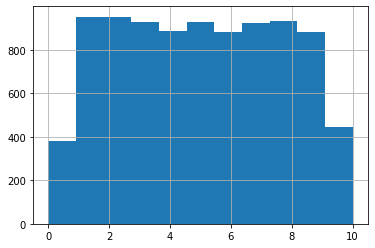

In [9]:
# построим гистограмму по столбцу Tenure
df['Tenure'].hist(bins=11)
plt.show()

в столбце Tenure менее 10% пропусков, так как природа их возникновения нам не известна, поэтому заполним пропущенные значение случайными числами:

In [22]:
data = (np.random.randint(0,10,size=df['Tenure'].isna().sum()))
df.loc[df['Tenure'].isna(),'Tenure']=data

In [15]:
weights = df['Tenure'].value_counts(normalize=True)
nulls = df[df['Tenure'].isna()]['Tenure']
new_df = random.choices(weights.index, weights=weights, k=len(nulls))
df['Tenure'] = df['Tenure'].fillna(pd.Series(new_df, index=nulls.index))

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


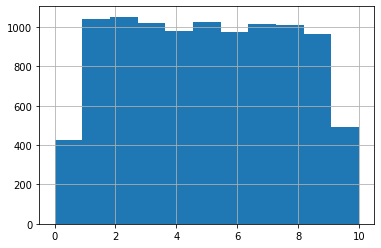

In [20]:
# Посмотрим повторно гистограмму по столбцу Tenure
df['Tenure'].hist(bins=11)
plt.show()

Так же в данных имеются столбцы, которые не нужны для обуения моделей, удаляем их:

In [21]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [22]:
#посмотрим на значения по стобцу
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [23]:
#посмотрим на значения по стобцу
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

категорийные значения в столбцах 'Geography' и 'Gender' преобразуем в числа техникой OHE

In [24]:
#избавляемся от дамми лавушки
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [25]:
df.sample(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
6827,718,49,10.0,0.00,1,1,0,184474.72,1,0,0,0
6391,726,38,5.0,126875.62,1,1,0,128052.29,0,0,0,0
7688,713,45,4.0,131038.14,1,1,0,74005.04,1,1,0,1
7488,538,42,4.0,80380.24,1,1,0,119216.46,0,1,0,0
6107,703,35,5.0,140691.08,2,1,0,167810.26,0,1,0,1
9608,700,44,9.0,0.00,2,1,0,142287.65,0,0,1,1
8780,820,39,9.0,111336.89,1,1,0,16770.31,1,1,0,1
5195,850,38,2.0,94652.04,1,1,1,171960.76,0,0,1,1
6449,693,45,2.0,116546.59,2,0,0,23140.28,1,1,0,1
6553,638,50,1.0,102645.48,1,1,0,168359.98,1,1,0,1


In [26]:
df.duplicated().sum()

0

полных дубликатов нет идем дальше

#### Формируем выбороки: обучающая, валидационная, тестовая

так как спрятанной тестовой выборки нет, разбиваем данные на три части:обучающую, валидационную и тестовую в соотношении 3:1:1.

In [27]:
#разделим на признаки и целевой признак
features = df.drop('Exited', axis=1)
target = df['Exited']

In [28]:
features.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8521,545,37,3.0,91184.01,1,1,0,105476.65,0,0,1
9905,645,41,2.0,93925.30,1,1,0,123982.14,1,0,1
6182,709,37,9.0,0.00,2,1,0,16733.59,0,0,0
9033,806,34,2.0,96152.68,2,1,0,143711.02,1,0,1
5368,538,62,3.0,75051.49,1,0,0,17682.02,0,0,0


In [29]:
target.sample(5)

2383    0
4249    0
9574    0
3199    1
7668    0
Name: Exited, dtype: int64

In [30]:
RANDOM_STATE=12345

In [31]:
#Разбиваем данные на обучающую/валидационную и тестовую выборку
features_train_val, features_test, target_train_val, target_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=RANDOM_STATE)

In [32]:
features_train_val.shape

(8000, 11)

In [33]:
features_test.shape

(2000, 11)

In [34]:
target_train_val.shape

(8000,)

In [35]:
target_test.shape

(2000,)

In [36]:
#Далее разделим обучающую и валидационную выборки
features_train, features_val, target_train, target_val = train_test_split(features_train_val, target_train_val, test_size=0.25, stratify=target_train_val, random_state=RANDOM_STATE)

In [37]:
features_train.shape

(6000, 11)

In [38]:
features_val.shape

(2000, 11)

In [39]:
target_train.shape

(6000,)

In [40]:
target_val.shape

(2000,)

#### Масштабируем признаки

In [41]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5536,636,45,7.0,0.00,2,1,1,159463.80,0,1,1
8530,808,33,2.0,103516.87,1,1,0,113907.80,0,0,0
1762,758,34,1.0,154139.45,1,1,1,60728.89,0,0,0
9090,809,39,5.0,0.00,1,1,0,77705.75,0,0,0
8777,603,24,1.0,165149.13,2,1,0,21858.28,0,1,1


In [42]:
#численные признаки для масштабирования 
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [43]:
# Проверим наличие аномальных значений по числовым столбцам
df[numeric].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.989900,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892756,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


In [44]:
#Создадим объект этой структуры и настроим его на обучающих данных:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [45]:
#Масштабируем численные признаки обучающей выборки 
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5536,-0.143332,0.577533,0.691735,-1.220573,0.797767,1,1,1.029613,0,1,1
8530,1.632702,-0.564119,-1.040924,0.435807,-0.916018,1,0,0.237986,0,0,0
1762,1.116413,-0.468981,-1.387455,1.245822,-0.916018,1,1,-0.686104,0,0,0
9090,1.643028,0.006707,-0.001328,-1.220573,-0.916018,1,0,-0.391097,0,0,0
8777,-0.484083,-1.420358,-1.387455,1.421989,0.797767,1,0,-1.361559,0,1,1


In [46]:
#Масштабируем численные признаки валидационной выборки 
features_val[numeric] = scaler.transform(features_val[numeric])
features_val.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9375,0.094161,0.862946,-0.347860,0.757050,0.797767,1,0,-0.308325,1,0,1
9536,-1.031349,0.292120,1.731331,0.838881,-0.916018,1,0,-0.645029,1,0,0
6344,2.066384,0.196983,-0.694392,-1.220573,0.797767,1,0,0.498373,0,0,1
4357,1.085435,-0.278706,1.038267,-1.220573,0.797767,1,0,1.331035,0,0,1
9120,0.548495,1.814323,-0.347860,0.266421,-0.916018,0,1,-0.261760,0,1,1


In [47]:
#Масштабируем численные признаки тестовой выборки 
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7837,2.066384,0.862946,-1.040924,-1.220573,-0.916018,1,0,1.202714,0,1,1
9505,0.011555,-1.039807,1.731331,0.052520,-0.916018,1,1,-0.443548,0,0,1
6208,0.662079,-0.468981,1.731331,-1.220573,0.797767,1,1,-0.347161,0,0,1
5642,1.364231,0.196983,-0.347860,-1.220573,-0.916018,1,0,0.568776,0,1,0
9643,-1.330797,0.196983,-1.040924,-1.220573,0.797767,1,1,0.223765,0,0,0


После масштабирования признаков для трех выборок, мы готовы приступить к исследованию задач с использованием моделей машинного обучения.

In [48]:
# Посмотрим количество объектов отрицательного и положительно класса
features[target == 0].shape, features[target == 1].shape

((7963, 11), (2037, 11))

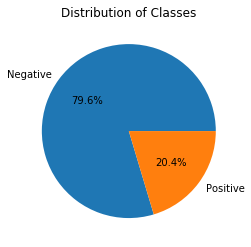

In [49]:
# Подсчет количества объектов отрицательного и положительного класса
negative_count = features[target == 0].shape[0]
positive_count = features[target == 1].shape[0]


# Создание круговой диаграммы
labels = ['Negative', 'Positive']
sizes = [negative_count, positive_count]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of Classes')

plt.show()

наблюдаем явный дисбаланс классов в 4 раза, обучим модели на несбалансированных данных и посмотрим а результаты

##### Вывод

На данном этапе производится предварительная обработка и подготовка данных для дальнейшего анализа и построения моделей. Импортировали необходимые библиотеки, провели первичный анализ данных, в столбце Tenure заполнили пропущенные значения. Удалили ненужные столбцы и проебразовали нужные столбцы  "Geography" и "Gender" с помощью техники OHЕ. Затем разделили признаки на целевой, масштабировали данные.

## Исследование задачи

2.1 Обучение моделей

##### DecisionTreeClassifier

In [50]:
best_f1_score = 0
best_f1_depth = 0

for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_val = model.predict(features_val)
    f1 = f1_score(target_val, predicted_val)
    print("max_depth =", depth, ": F1 Score =", f1)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_depth = depth

print("Best F1 Score:", best_f1_score)
print("Best depth for F1 Score:", best_f1_depth)

max_depth = 1 : F1 Score = 0.0
max_depth = 2 : F1 Score = 0.514792899408284
max_depth = 3 : F1 Score = 0.375
max_depth = 4 : F1 Score = 0.5168539325842697
max_depth = 5 : F1 Score = 0.46045694200351495
max_depth = 6 : F1 Score = 0.532051282051282
max_depth = 7 : F1 Score = 0.5460218408736349
max_depth = 8 : F1 Score = 0.5747460087082729
max_depth = 9 : F1 Score = 0.5305514157973175
max_depth = 10 : F1 Score = 0.5426136363636364
max_depth = 11 : F1 Score = 0.5430107526881721
max_depth = 12 : F1 Score = 0.5136897001303781
max_depth = 13 : F1 Score = 0.5063938618925832
max_depth = 14 : F1 Score = 0.5057766367137355
max_depth = 15 : F1 Score = 0.4911392405063291
max_depth = 16 : F1 Score = 0.49070631970260226
max_depth = 17 : F1 Score = 0.49814126394052044
max_depth = 18 : F1 Score = 0.4743276283618582
max_depth = 19 : F1 Score = 0.4963503649635037
max_depth = 20 : F1 Score = 0.4903846153846154
Best F1 Score: 0.5747460087082729
Best depth for F1 Score: 8


##### RandomForestClassifier

In [53]:
best_f1_score = 0
best_f1_depth = 0

for depth in range(1, 21):
    model = RandomForestClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_val = model.predict(features_val)
    f1 = f1_score(target_val, predicted_val)
    print("max_depth =", depth, ": F1 Score =", f1)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_depth = depth

print("Best F1 Score:", best_f1_score)
print("Best depth for F1 Score:", best_f1_depth)

max_depth = 1 : F1 Score = 0.0
max_depth = 2 : F1 Score = 0.16629213483146066
max_depth = 3 : F1 Score = 0.21645021645021648
max_depth = 4 : F1 Score = 0.3954372623574145
max_depth = 5 : F1 Score = 0.46319569120287246
max_depth = 6 : F1 Score = 0.48780487804878053
max_depth = 7 : F1 Score = 0.503448275862069
max_depth = 8 : F1 Score = 0.5317725752508361
max_depth = 9 : F1 Score = 0.5266666666666666
max_depth = 10 : F1 Score = 0.5394736842105264
max_depth = 11 : F1 Score = 0.546644844517185
max_depth = 12 : F1 Score = 0.5614035087719298
max_depth = 13 : F1 Score = 0.580441640378549
max_depth = 14 : F1 Score = 0.5620094191522763
max_depth = 15 : F1 Score = 0.5638629283489096
max_depth = 16 : F1 Score = 0.5617283950617283
max_depth = 17 : F1 Score = 0.5644171779141105
max_depth = 18 : F1 Score = 0.563165905631659
max_depth = 19 : F1 Score = 0.548780487804878
max_depth = 20 : F1 Score = 0.5674846625766871
Best F1 Score: 0.580441640378549
Best depth for F1 Score: 13


##### LogisticRegression

In [54]:
best_f1_score = 0
best_f1_C = 0

for C in np.linspace(0.1, 1.0, 10):
    model = LogisticRegression(random_state=12345, C=C)
    model.fit(features_train, target_train)
    predicted_val = model.predict(features_val)
    auc_roc = roc_auc_score(target_val, predicted_val)
    f1 = f1_score(target_val, predicted_val)
    print("C =", C, ": AUC-ROC =", auc_roc, "F1 Score =", f1)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_C = C

print("Best F1 Score:", best_f1_score)
print("Best C for F1 Score:", best_f1_C)

C = 0.1 : AUC-ROC = 0.5854382888281193 F1 Score = 0.3021032504780115
C = 0.2 : AUC-ROC = 0.590639175384938 F1 Score = 0.3163841807909604
C = 0.30000000000000004 : AUC-ROC = 0.590639175384938 F1 Score = 0.3163841807909604
C = 0.4 : AUC-ROC = 0.5903253021897089 F1 Score = 0.3157894736842105
C = 0.5 : AUC-ROC = 0.5915538034182102 F1 Score = 0.3189493433395873
C = 0.6 : AUC-ROC = 0.591239930222981 F1 Score = 0.31835205992509363
C = 0.7000000000000001 : AUC-ROC = 0.591239930222981 F1 Score = 0.31835205992509363
C = 0.8 : AUC-ROC = 0.591239930222981 F1 Score = 0.31835205992509363
C = 0.9 : AUC-ROC = 0.591239930222981 F1 Score = 0.31835205992509363
C = 1.0 : AUC-ROC = 0.590926057027752 F1 Score = 0.3177570093457944
Best F1 Score: 0.3189493433395873
Best C for F1 Score: 0.5


##### Вывод

Мы обучили три модели без учета дисбаланса классов, и модель случайного леса показала наилучший результат по метрике F1 Score. Теперь мы можем рассчитать дополнительную метрику AUC-ROC для оценки качества модели

In [86]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=13)
model.fit(features_train, target_train)

predicted_val = model.predict(features_val)
f1 = f1_score(target_val, predicted_val)

probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]
auc_roc = roc_auc_score(target_val, probabilities_one_val)

print('F1 Score на валидационной выборке:', f1)
print('AUC-ROC на валидационной выборке:', auc_roc)

F1 Score на валидационной выборке: 0.580441640378549
AUC-ROC на валидационной выборке: 0.8615263954247004


In [100]:
# Создание списка со значениями
results_no_balance = [
    {'Модель': 'Decision Tree', 'Балансировка': 'Нет', 'Глубина': 8, 'F1 Score': 0.5747460087082729},
    {'Модель': 'Random Forest', 'Балансировка': 'Нет', 'Глубина': 13, 'F1 Score': 0.580441640378549},
    {'Модель': 'Logistic Regression', 'Балансировка': 'Нет', 'C': 0.5, 'F1 Score': 0.3189493433395873},
     ]

# Создание DataFrame
df_results_no_balance = pd.DataFrame(results_no_balance)

# Вывод таблицы
df_results_no_balance

,Модель,Балансировка,Глубина,F1 Score,C
0,Decision Tree,Нет,8.0,0.574746,NaN
1,Random Forest,Нет,13.0,0.580442,NaN
2,Logistic Regression,Нет,NaN,0.318949,0.5


Довольно хороший результат auc_roc 0.86, теперь же обучим модели после устранения дисбаланса.

## Борьба с дисбалансом

Ранее уже видели, что дизбаланс целевого отношения 4:1. Напишем функцию апсемплинга(с кф 4) и даунсемплинга(с кф 0.25), и проверим модели на новых наборах данных.

In [74]:
# Увеличиваем число наблюдений
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [75]:
# Уменьшаем число наблюдений
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [76]:
features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, repeat=4)
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, 0.25)

###### Проверим модели на апсемплинге:

##### DecisionTreeClassifier

In [77]:
best_f1_score = 0
best_f1_depth = 0

for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled_train, target_upsampled_train)
    predicted_val = model.predict(features_val)
    f1 = f1_score(target_val, predicted_val)
    print("max_depth =", depth, ": F1 Score =", f1)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_depth = depth

print("Best F1 Score:", best_f1_score)
print("Best depth for F1 Score:", best_f1_depth)

max_depth = 1 : F1 Score = 0.49916527545909845
max_depth = 2 : F1 Score = 0.5074135090609556
max_depth = 3 : F1 Score = 0.5074135090609556
max_depth = 4 : F1 Score = 0.5422594142259414
max_depth = 5 : F1 Score = 0.5618556701030928
max_depth = 6 : F1 Score = 0.5770609318996416
max_depth = 7 : F1 Score = 0.5724703737465816
max_depth = 8 : F1 Score = 0.543438077634011
max_depth = 9 : F1 Score = 0.5511961722488039
max_depth = 10 : F1 Score = 0.5232558139534884
max_depth = 11 : F1 Score = 0.5174537987679672
max_depth = 12 : F1 Score = 0.5202072538860104
max_depth = 13 : F1 Score = 0.5011185682326621
max_depth = 14 : F1 Score = 0.47544642857142855
max_depth = 15 : F1 Score = 0.4782122905027933
max_depth = 16 : F1 Score = 0.4691075514874142
max_depth = 17 : F1 Score = 0.4693396226415094
max_depth = 18 : F1 Score = 0.4830097087378641
max_depth = 19 : F1 Score = 0.5079365079365079
max_depth = 20 : F1 Score = 0.4727272727272727
Best F1 Score: 0.5770609318996416
Best depth for F1 Score: 6


##### RandomForestClassifier

In [78]:
best_f1_score = 0
best_f1_depth = 0

for depth in range(1, 21):
    model = RandomForestClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled_train, target_upsampled_train)
    predicted_val = model.predict(features_val)
    f1 = f1_score(target_val, predicted_val)
    print("max_depth =", depth, ": F1 Score =", f1)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_depth = depth

print("Best F1 Score:", best_f1_score)
print("Best depth for F1 Score:", best_f1_depth)

max_depth = 1 : F1 Score = 0.5275862068965518
max_depth = 2 : F1 Score = 0.5631244323342416
max_depth = 3 : F1 Score = 0.5836363636363636
max_depth = 4 : F1 Score = 0.5857819905213271
max_depth = 5 : F1 Score = 0.5969289827255279
max_depth = 6 : F1 Score = 0.6051080550098232
max_depth = 7 : F1 Score = 0.6126482213438734
max_depth = 8 : F1 Score = 0.6286286286286286
max_depth = 9 : F1 Score = 0.6131687242798354
max_depth = 10 : F1 Score = 0.6339869281045752
max_depth = 11 : F1 Score = 0.6281179138321995
max_depth = 12 : F1 Score = 0.6144721233689204
max_depth = 13 : F1 Score = 0.6166868198307133
max_depth = 14 : F1 Score = 0.598503740648379
max_depth = 15 : F1 Score = 0.6069142125480153
max_depth = 16 : F1 Score = 0.6141522029372496
max_depth = 17 : F1 Score = 0.6040268456375839
max_depth = 18 : F1 Score = 0.6040268456375839
max_depth = 19 : F1 Score = 0.6
max_depth = 20 : F1 Score = 0.6029609690444145
Best F1 Score: 0.6339869281045752
Best depth for F1 Score: 10


##### LogisticRegression

In [81]:
best_f1_score = 0
best_f1_C = 0

for C in np.linspace(0.1, 1.0, 10):
    model = LogisticRegression(random_state=12345, C=C)
    model.fit(features_upsampled_train, target_upsampled_train)
    predicted_val = model.predict(features_val)
    f1 = f1_score(target_val, predicted_val)
    print("C =", C, "F1 Score =", f1)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_C = C

print("Best F1 Score:", best_f1_score)
print("Best C for F1 Score:", best_f1_C)

C = 0.1 F1 Score = 0.5085616438356165
C = 0.2 F1 Score = 0.5085616438356165
C = 0.30000000000000004 F1 Score = 0.5081266039349872
C = 0.4 F1 Score = 0.5081266039349872
C = 0.5 F1 Score = 0.5081266039349872
C = 0.6 F1 Score = 0.5076923076923077
C = 0.7000000000000001 F1 Score = 0.5081266039349872
C = 0.8 F1 Score = 0.5081266039349872
C = 0.9 F1 Score = 0.5081266039349872
C = 1.0 F1 Score = 0.5081266039349872
Best F1 Score: 0.5085616438356165
Best C for F1 Score: 0.1


In [83]:
# Создание списка со значениями
results_upsampled = [
    {'Модель': 'Decision Tree', 'Балансировка': 'upsampled', 'Глубина': 6, 'F1 Score': 0.5770609318996416},
    {'Модель': 'Random Forest', 'Балансировка': 'upsampled', 'Глубина': 10, 'F1 Score': 0.6339869281045752},
    {'Модель': 'Logistic Regression', 'Балансировка': 'upsampled', 'C': 0.1, 'F1 Score': 0.5085616438356165}
]

# Создание DataFrame
df_results_upsampled = pd.DataFrame(results_upsampled)

# Вывод таблицы

display(df_results_upsampled, df_results_no_balance)

,Модель,Балансировка,Глубина,F1 Score,C
0,Decision Tree,upsampled,6.0,0.577061,NaN
1,Random Forest,upsampled,10.0,0.633987,NaN
2,Logistic Regression,upsampled,NaN,0.508562,0.1


,Модель,Балансировка,Глубина,F1 Score,C
0,Decision Tree,Нет,8.0,0.574746,NaN
1,Random Forest,Нет,13.0,0.580442,NaN
2,Logistic Regression,Нет,NaN,0.318949,0.5


Как видим на апсемплинге результаты ф1 уже лучше, у модели Случайный лес - ф1 0.63, и у логист. регрессии 0.50. А решающее дерево без изменений. Теперь же  рассчитаем дополнительную метрику AUC-ROC для оценки качества модели

In [89]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=10)
model.fit(features_upsampled_train, target_upsampled_train)

predicted_val = model.predict(features_val)
f1 = f1_score(target_val, predicted_val)

probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]
auc_roc = roc_auc_score(target_val, probabilities_one_val)

print('F1 Score на валидационной выборке:', f1)
print('AUC-ROC на валидационной выборке:', auc_roc)

F1 Score на валидационной выборке: 0.6339869281045752
AUC-ROC на валидационной выборке: 0.8707274300494638


результат чуть лучше на апсемплинге auc_roc 0.87, теперь же посмотрим модели на даунсемплинге:

###### Проверим модели на даунсемплинге:

##### DecisionTreeClassifier

In [103]:
best_f1_score = 0
best_f1_depth = 0

for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled_train, target_downsampled_train)
    predicted_val = model.predict(features_val)
    f1 = f1_score(target_val, predicted_val)
    print("max_depth =", depth, ": F1 Score =", f1)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_depth = depth

print("Best F1 Score:", best_f1_score)
print("Best depth for F1 Score:", best_f1_depth)

max_depth = 1 : F1 Score = 0.4804381846635367
max_depth = 2 : F1 Score = 0.4860681114551083
max_depth = 3 : F1 Score = 0.5159817351598174
max_depth = 4 : F1 Score = 0.5228548516439455
max_depth = 5 : F1 Score = 0.5551894563426688
max_depth = 6 : F1 Score = 0.5921450151057401
max_depth = 7 : F1 Score = 0.5510026155187445
max_depth = 8 : F1 Score = 0.5452881976212259
max_depth = 9 : F1 Score = 0.5068027210884353
max_depth = 10 : F1 Score = 0.5046413502109705
max_depth = 11 : F1 Score = 0.49786142001710865
max_depth = 12 : F1 Score = 0.49957374254049447
max_depth = 13 : F1 Score = 0.49484536082474223
max_depth = 14 : F1 Score = 0.4910485933503836
max_depth = 15 : F1 Score = 0.4957698815566835
max_depth = 16 : F1 Score = 0.48120300751879697
max_depth = 17 : F1 Score = 0.4820083682008368
max_depth = 18 : F1 Score = 0.4818871103622578
max_depth = 19 : F1 Score = 0.48612279226240535
max_depth = 20 : F1 Score = 0.4818871103622578
Best F1 Score: 0.5921450151057401
Best depth for F1 Score: 6


##### RandomForestClassifier

In [94]:
best_f1_score = 0
best_f1_depth = 0

for depth in range(1, 21):
    model = RandomForestClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled_train, target_downsampled_train)
    predicted_val = model.predict(features_val)
    f1 = f1_score(target_val, predicted_val)
    print("max_depth =", depth, ": F1 Score =", f1)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_depth = depth

print("Best F1 Score:", best_f1_score)
print("Best depth for F1 Score:", best_f1_depth)

max_depth = 1 : F1 Score = 0.5417057169634489
max_depth = 2 : F1 Score = 0.5806451612903226
max_depth = 3 : F1 Score = 0.5884615384615385
max_depth = 4 : F1 Score = 0.6025267249757046
max_depth = 5 : F1 Score = 0.5990147783251232
max_depth = 6 : F1 Score = 0.5998052580331061
max_depth = 7 : F1 Score = 0.6039215686274509
max_depth = 8 : F1 Score = 0.6104651162790697
max_depth = 9 : F1 Score = 0.614481409001957
max_depth = 10 : F1 Score = 0.5994236311239194
max_depth = 11 : F1 Score = 0.6061185468451242
max_depth = 12 : F1 Score = 0.6159769008662176
max_depth = 13 : F1 Score = 0.6009478672985783
max_depth = 14 : F1 Score = 0.5966228893058162
max_depth = 15 : F1 Score = 0.5981132075471698
max_depth = 16 : F1 Score = 0.5896946564885496
max_depth = 17 : F1 Score = 0.597918637653737
max_depth = 18 : F1 Score = 0.5950095969289827
max_depth = 19 : F1 Score = 0.5980952380952381
max_depth = 20 : F1 Score = 0.5881226053639846
Best F1 Score: 0.6159769008662176
Best depth for F1 Score: 12


##### LogisticRegression

In [95]:
best_f1_score = 0
best_f1_C = 0

for C in np.linspace(0.1, 1.0, 10):
    model = LogisticRegression(random_state=12345, C=C)
    model.fit(features_downsampled_train, target_downsampled_train)
    predicted_val = model.predict(features_val)
    f1 = f1_score(target_val, predicted_val)
    print("C =", C, "F1 Score =", f1)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_f1_C = C
        
print("Best F1 Score:", best_f1_score)
print("Best C for F1 Score:", best_f1_C)


C = 0.1 F1 Score = 0.5086206896551725
C = 0.2 F1 Score = 0.5055889939810834
C = 0.30000000000000004 F1 Score = 0.5051369863013698
C = 0.4 F1 Score = 0.504704875962361
C = 0.5 F1 Score = 0.504704875962361
C = 0.6 F1 Score = 0.5042735042735043
C = 0.7000000000000001 F1 Score = 0.5038428693424424
C = 0.8 F1 Score = 0.5034129692832764
C = 0.9 F1 Score = 0.5034129692832764
C = 1.0 F1 Score = 0.5034129692832764
Best F1 Score: 0.5086206896551725
Best C for F1 Score: 0.1


In [104]:
# Создание списка со значениями
results_downsampled = [
    {'Модель': 'Decision Tree', 'Балансировка': 'downsampled', 'Глубина': 6, 'F1 Score': 0.5921450151057401},
    {'Модель': 'Random Forest', 'Балансировка': 'downsampled', 'Глубина': 12, 'F1 Score': 0.6159769008662176},
    {'Модель': 'Logistic Regression', 'Балансировка': 'downsampled', 'C': 0.1, 'F1 Score': 0.5086206896551725}
]

# Создание DataFrame
df_results_downsampled = pd.DataFrame(results_downsampled)

# Вывод таблицы
display(df_results_downsampled, df_results_upsampled, df_results_no_balance)

,Модель,Балансировка,Глубина,F1 Score,C
0,Decision Tree,downsampled,6.0,0.592145,NaN
1,Random Forest,downsampled,12.0,0.615977,NaN
2,Logistic Regression,downsampled,NaN,0.508621,0.1


,Модель,Балансировка,Глубина,F1 Score,C
0,Decision Tree,upsampled,6.0,0.577061,NaN
1,Random Forest,upsampled,10.0,0.633987,NaN
2,Logistic Regression,upsampled,NaN,0.508562,0.1


,Модель,Балансировка,Глубина,F1 Score,C
0,Decision Tree,Нет,8.0,0.574746,NaN
1,Random Forest,Нет,13.0,0.580442,NaN
2,Logistic Regression,Нет,NaN,0.318949,0.5


In [98]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=12)
model.fit(features_downsampled_train, target_downsampled_train)

predicted_val = model.predict(features_val)
f1 = f1_score(target_val, predicted_val)

probabilities_val = model.predict_proba(features_val)
probabilities_one_val = probabilities_val[:, 1]
auc_roc = roc_auc_score(target_val, probabilities_one_val)

print('F1 Score на валидационной выборке:', f1)
print('AUC-ROC на валидационной выборке:', auc_roc)

F1 Score на валидационной выборке: 0.6159769008662176
AUC-ROC на валидационной выборке: 0.8664781885120869


на даунсемплинге результат AUC-ROC такой же как и на несбалансированных данных

Как видим лучше всего себя показал апсемлинг, лучшая модель случайный лес:
- ф1 0.633987	
- глубина 10

Будем использовать эту модель и гиперпараметры для финальной модели.

## Тестирование модели

In [101]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=10) 
model.fit(features_upsampled_train, target_upsampled_train)
predicted = model.predict(features_test)
result = f1_score(target_test, predicted)
print('f1 на лучшей модели:', result)

f1 на лучшей модели: 0.6259541984732825


как видим, получили F1-меру равную 0.62 Это указывает на хорошую сбалансированность модели в предсказании положительного и отрицательного классов.

In [102]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

0.8664442562747647

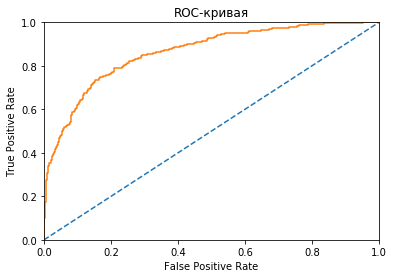

In [96]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')


plt.show()

Мы получили значение площади под ROC-кривой (AUC-ROC) равное 0.86 Это указывает на хорошую способность модели отличать между положительными и отрицательными классами и предсказывать вероятности принадлежности к положительному классу.

##### Итоговый Вывод

В результате исследования данных клиентов банка, было обнаружено, что параметр "Tenure" содержит пропущенные значения, которые не удалось объяснить зависимостью от других атрибутов. Поэтому эти пропуски мы заполнили случайными значениями.

Также был выявлен дисбаланс целевых параметров, где количество ушедших клиентов было значительно меньше, чем количество действующих клиентов. Для решения этой проблемы были применены два подхода - апсемплинг и даунсемплинг. При этом апсемплинг показал лучшие результаты.

Для обучения моделей классификации (случайный лес деревьев, дерево решений и логистическая регрессия) были подобраны и настроены гиперпараметры. Из них случайный лес деревьев показал наилучшую производительность.

На тестовых данных была проверена обученная модель, и она продемонстрировала хорошие результаты с точки зрения f1-метрики (0.62) и AUC-ROC (0.86). Это указывает на сбалансированность модели в терминах точности и полноты.

В целом, проведенный анализ данных и обучение моделей позволяют сделать вывод о том, что модель является достаточно надежной и способной предсказывать отток клиентов банка.